In [1]:
from pixell import curvedsky, enmap, utils, enplot
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

Let's set up a geometry, and then place 200 points randomly in RA and DEC.

In [2]:
shape,wcs = enmap.fullsky_geometry(res=np.deg2rad(0.25),proj='car')
nside = 256

In [3]:
hp.nside2npix(nside) / np.prod(shape)

0.7574664817383264

In [4]:
Npoints = 200

In [5]:
RA = np.random.rand(Npoints) * 2 * np.pi
DEC = np.random.rand(Npoints) * np.pi - np.pi / 2

Now let's add them to a CAR map.

In [6]:
car_map = enmap.zeros(shape, wcs=wcs)

decpix, rapix = enmap.sky2pix(shape, wcs, np.vstack([DEC, RA]))
rapix = np.round(rapix).astype(int)
decpix = np.round(decpix).astype(int)

for i in range(Npoints):
    ra_ = rapix[i] % shape[1]
    dec_ = decpix[i]
    car_map[dec_, ra_] = 1.0
    
car_map /= enmap.pixsizemap(shape, wcs)

Now let's add those same points to a Healpix map.

In [7]:
hp_map = np.zeros(hp.nside2npix(nside))

LAT = np.rad2deg(DEC)
LON = np.rad2deg(RA)

for i in range(Npoints):
    hp_map[hp.ang2pix(nside, LON, LAT, lonlat=True)] = 1.0
    
hp_map /= hp.nside2pixarea(nside)

In [8]:
alm_car = curvedsky.map2alm(car_map, lmax=3*nside-1)
alm_hp = hp.map2alm(hp_map)

In [9]:
def mean_pixwin(m0, lmax):
    m1 = enmap.rand_gauss(m0.shape, m0.wcs)
    m2 = enmap.apply_window(m1.copy())
    cl1 = hp.alm2cl(curvedsky.map2alm(m1, lmax=lmax))
    cl2 = hp.alm2cl(curvedsky.map2alm(m2, lmax=lmax))
    return np.sqrt(cl2/cl1)

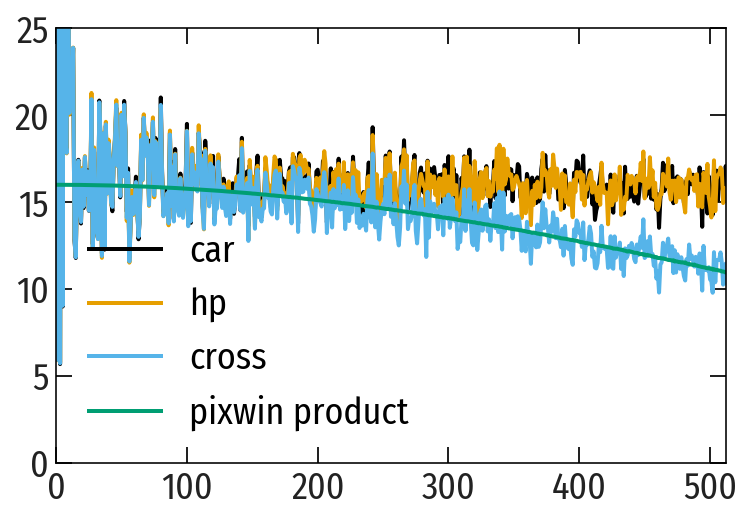

In [10]:
plt.plot(hp.alm2cl(alm_car), "-",  label="car")
plt.plot(hp.alm2cl(alm_hp), "-", label="hp")
plt.plot(hp.alm2cl(alm_hp, alm_car), "-", label="cross")

carpx = mean_pixwin(car_map, lmax=3*nside-1)
plt.plot( hp.pixwin(nside) * carpx * 16, label="pixwin product")

plt.xlim(0, 2*nside)
plt.ylim(0,25)
plt.legend()

When you cross-correlate two maps with different pixelisations, you incur a loss of power that is the product of the pixel windows.